# Models



|            | [1] DeepFold | [2] SeqVec |
|------------|--------------|------------|
| A. DBSCAN  | A1 | A2 |
| B. HDBSCAN | B1 | B2 |
| C. OPTICS  | C1 | C2 |



Model files generated

```
Upload: model_outputs/A1-DBSCAN-DeepFold-cluster_stats.parquet
Upload: model_outputs/B2-HDBSCAN-SeqVec-all_protein_combos_per_cluster.parquet
Upload: model_outputs/a1_model.pkl
Upload: model_outputs/A1-DBSCAN-DeepFold-all_protein_combos_per_cluster.parquet
Upload: model_outputs/B1-HDBSCAN-DeepFold-cluster_stats.parquet
Upload: model_outputs/b2_model.pkl
Upload: model_outputs/B2-HDBSCAN-SeqVec-cluster_stats.parquet
Upload: model_outputs/a2_model.pkl
Upload: model_outputs/b1_model.pkl
Upload: model_outputs/A2-DBSCAN-SeqVec-all_protein_combos_per_cluster.parquet
Upload: model_outputs/B1-HDBSCAN-DeepFold-all_protein_combos_per_cluster.parquet
Upload: model_outputs/A2-DBSCAN-SeqVec-cluster_stats.parquet
```

In [1]:
from utils import gcs_utils as gcs
from utils import model_and_evaluate_cluster as ev

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

import importlib
import hdbscan
from sklearn.cluster import DBSCAN
import io
import os
import pickle
import datetime


In [2]:
prefix='model_outputs/no_cluster_size_limit/'
a1_model = gcs.download_pkl(prefix+'A1_model.pkl')
a2_model = gcs.download_pkl(prefix+'A2_model.pkl')
a3_model = gcs.download_pkl(prefix+'A3_model.pkl')
b1_model = gcs.download_pkl(prefix+'B1_model.pkl')
b2_model = gcs.download_pkl(prefix+'B2_model.pkl')
b3_model = gcs.download_pkl(prefix+'B3_model.pkl')


In [3]:

a1_clusters = gcs.download_pkl(prefix+'A1_clusters.pkl')
a2_clusters = gcs.download_pkl(prefix+'A2_clusters.pkl')
a3_clusters = gcs.download_pkl(prefix+'A3_clusters.pkl')
b1_clusters = gcs.download_pkl(prefix+'B1_clusters.pkl')
b2_clusters = gcs.download_pkl(prefix+'B2_clusters.pkl')
b3_clusters = gcs.download_pkl(prefix+'B3_clusters.pkl')


In [6]:

a1_all_protein_combos_per_cluster = gcs.download_parquet(prefix+'A1-DBSCAN-DeepFold-all_protein_combos_per_cluster.parquet')
a2_all_protein_combos_per_cluster = gcs.download_parquet(prefix+'A2-DBSCAN-SeqVec-all_protein_combos_per_cluster.parquet')
# a3_all_protein_combos_per_cluster = gcs.download_parquet(prefix+'A3-DBSCAN-SeqVec-all_protein_combos_per_cluster.parquet')
b1_all_protein_combos_per_cluster = gcs.download_parquet(prefix+'B1-HDBSCAN-DeepFold-all_protein_combos_per_cluster.parquet')
b2_all_protein_combos_per_cluster = gcs.download_parquet(prefix+'B2-HDBSCAN-SeqVec-all_protein_combos_per_cluster.parquet')
# b3_all_protein_combos_per_cluster = gcs.download_parquet(prefix+'B3-HDBSCAN-SeqVec-all_protein_combos_per_cluster.parquet')


In [5]:
b1_clusters

,protein,cluster_label
0,Q53HV7,434
1,A4UGR9,-1
2,P09529,-1
3,P19622,-1
4,Q9UPU9,-1
...,...,...
20296,Q9NQ76,-1
20297,A6NKD9,580
20298,Q9UPR3,-1
20299,Q9NZZ3,-1


# Output Data Review

In [193]:
a1_all_protein_combos_per_cluster.shape

(29886034, 3)

In [194]:
a1_all_protein_combos_per_cluster.head()

,query_protein,target_protein,cluster
1,P09529,Q9UPU9,0
2,P09529,Q9HCL3,0
3,P09529,Q2I0M5,0
4,P09529,Q9Y639,0
5,P09529,Q8IWF6,0


In [199]:
pivot = a1_all_protein_combos_per_cluster.pivot_table(index='cluster',
                                             values=['target_protein', 'query_protein'],
                                             aggfunc=pd.Series.nunique)
pivot.sort_values('query_protein', ascending=False)

,query_protein,target_protein
cluster,,
0,5447,5447
23,250,250
35,211,211
12,179,179
19,110,110
...,...,...
578,2,2
582,2,2
583,2,2


In [200]:
pivot = a2_all_protein_combos_per_cluster.pivot_table(index='cluster',
                                             values=['target_protein', 'query_protein'],
                                             aggfunc=pd.Series.nunique)
pivot.sort_values('query_protein', ascending=False)

,query_protein,target_protein
cluster,,
28,691,691
19,426,426
107,152,152
151,127,127
329,103,103
...,...,...
764,2,2
765,2,2
767,2,2


In [201]:
pivot = b1_all_protein_combos_per_cluster.pivot_table(index='cluster',
                                             values=['target_protein', 'query_protein'],
                                             aggfunc=pd.Series.nunique)
pivot.sort_values('query_protein', ascending=False)

,query_protein,target_protein
cluster,,
519,308,308
550,254,254
486,126,126
436,124,124
432,85,85
...,...,...
297,5,5
467,5,5
294,5,5


In [202]:
pivot = b2_all_protein_combos_per_cluster.pivot_table(index='cluster',
                                             values=['target_protein', 'query_protein'],
                                             aggfunc=pd.Series.nunique)
pivot.sort_values('query_protein', ascending=False)

,query_protein,target_protein
cluster,,
579,416,416
578,195,195
755,129,129
421,99,99
667,89,89
...,...,...
451,5,5
180,5,5
625,5,5


In [206]:

def get_noise_stats(model):
    labels = np.unique(model.labels_, return_counts=True)
    noise_ct = labels[1][0]
    max_cluster_size = labels[1][1:].max()
    num_proteins=model.labels_.shape[0]


    return {"Number of clusters categories (incl. noise)": np.unique(model.labels_, return_counts=True)[1].shape[0],
            "Number of clusters (excl. noise)": np.unique(model.labels_, return_counts=True)[1].shape[0]-1,
            "Noise": noise_ct,
            "Largest non-noise cluster": max_cluster_size,
            "Noise as % of total":  noise_ct/num_proteins,
            "Noise and largest cluster as % of total": (noise_ct+max_cluster_size)/num_proteins}


In [207]:
get_noise_stats(a1_model)

{'Number of clusters categories (incl. noise)': 1223,
 'Number of clusters (excl. noise)': 1222,
 'Noise': 10240,
 'Largest non-noise cluster': 5451,
 'Noise as % of total': 0.504408649820206,
 'Noise and largest cluster as % of total': 0.7729175902664893}

In [208]:
get_noise_stats(a2_model)

{'Number of clusters categories (incl. noise)': 1607,
 'Number of clusters (excl. noise)': 1606,
 'Noise': 12966,
 'Largest non-noise cluster': 691,
 'Noise as % of total': 0.6323644166991806,
 'Noise and largest cluster as % of total': 0.6660651580179477}

In [209]:
get_noise_stats(b1_model)

{'Number of clusters categories (incl. noise)': 608,
 'Number of clusters (excl. noise)': 607,
 'Noise': 14056,
 'Largest non-noise cluster': 308,
 'Noise as % of total': 0.692379685729767,
 'Noise and largest cluster as % of total': 0.7075513521501404}

In [210]:
get_noise_stats(b2_model)

{'Number of clusters categories (incl. noise)': 758,
 'Number of clusters (excl. noise)': 757,
 'Noise': 11579,
 'Largest non-noise cluster': 416,
 'Noise as % of total': 0.5647190792040577,
 'Noise and largest cluster as % of total': 0.5850078033554429}

# Input Data Generation

# Download Embeddings

## 1. DeepFold

In [55]:
importlib.reload(ev)

<module 'utils.model_and_evaluate_cluster' from '/Users/haeranglee/Documents/pss/utils/model_and_evaluate_cluster.py'>

In [51]:
prefix = 'embeddings/DeepFold/withMask=false/'
keys = gcs.list_file_paths(prefix)[1:]

In [52]:
keys

['gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_00.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_01.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_02.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_03.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_04.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_05.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_06.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_07.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_08.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_09.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_10.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/wit

In [56]:
X_deepfold, missing_deepfold, protein_id_deepfold = ev.import_deepfold_embeddings(keys)

embeddings/DeepFold/withMask=false/embeddings_00.csv
embeddings/DeepFold/withMask=false/embeddings_01.csv
embeddings/DeepFold/withMask=false/embeddings_02.csv
embeddings/DeepFold/withMask=false/embeddings_03.csv
embeddings/DeepFold/withMask=false/embeddings_04.csv
embeddings/DeepFold/withMask=false/embeddings_05.csv
embeddings/DeepFold/withMask=false/embeddings_06.csv
embeddings/DeepFold/withMask=false/embeddings_07.csv
embeddings/DeepFold/withMask=false/embeddings_08.csv
embeddings/DeepFold/withMask=false/embeddings_09.csv
embeddings/DeepFold/withMask=false/embeddings_10.csv
embeddings/DeepFold/withMask=false/embeddings_11.csv
embeddings/DeepFold/withMask=false/embeddings_12.csv
embeddings/DeepFold/withMask=false/embeddings_13.csv
embeddings/DeepFold/withMask=false/embeddings_14.csv
embeddings/DeepFold/withMask=false/embeddings_15.csv
embeddings/DeepFold/withMask=false/embeddings_16.csv
embeddings/DeepFold/withMask=false/embeddings_17.csv
embeddings/DeepFold/withMask=false/embeddings_

In [33]:
print("X_deepfold.shape", X_deepfold.shape)
print("missing_deepfold.shape", missing_deepfold.shape)
print("protein_id_deepfold.shape", protein_id_deepfold.shape)

X_deepfold.shape (20301, 398)
missing_deepfold.shape (203,)
protein_id_deepfold.shape (20301,)


(100, 100)
0.05531216821492077 1.3958603498450148 1.1258949664407183


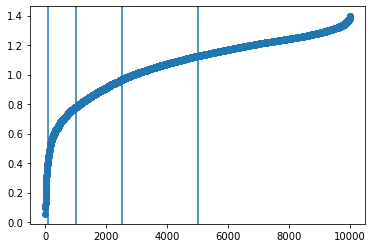

In [32]:
# Show euclidean distances between a random set of points

ed = euclidean_distances(X_deepfold[np.random.choice(range(len(X_deepfold)), 100)],
                         X_deepfold[np.random.choice(range(len(X_deepfold)), 100)]
                        )
print(ed.shape)

min_ed = np.min(ed)
max_ed = np.max(ed)
median_ed = np.median(ed)

print(min_ed, max_ed, median_ed)
ed_flatten = ed.flatten()

plt.scatter(range(len(ed_flatten)), np.sort(ed_flatten))
plt.axvline(len(ed_flatten)/2)
plt.axvline(len(ed_flatten)/4)
plt.axvline(len(ed_flatten)/10)
plt.axvline(len(ed_flatten)/100)
plt.show()

The euclidean distance among the proteins range from 0 to 1.41, median is about 1.12. And based on the plot of euclidean distances, it appears that there are a lot of proteins that are similar to each other and there is a long tail of different proteins. 

## 2. SeqVec

In [57]:
prefix = 'embeddings/SeqVec/'
keys = gcs.list_file_paths(prefix)

# There's only one file 
key = gcs.uri_to_bucket_and_key(keys[1])[1]
seqvec_df = gcs.download_pkl(key)

# Convert pd Series into np arr
X_seqvec = np.stack( seqvec_df["seqvec"]).astype(np.float64)

X_seqvec.shape

(20504, 1024)

In [60]:
protein_id_seqvec = np.array(seqvec_df["protein_id"])
protein_id_seqvec.shape

(20504,)

# 3. DeepFold without Disordered

In [161]:
prefix = 'embeddings/DeepFold/withMask=true/'
keys = gcs.list_file_paths(prefix)[1:]

In [162]:
keys

['gs://capstone-fall21-protein/embeddings/DeepFold/withMask=true/deepfold_00.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=true/deepfold_01.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=true/deepfold_02.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=true/deepfold_03.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=true/deepfold_04.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=true/deepfold_05.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=true/deepfold_06.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=true/deepfold_07.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=true/deepfold_08.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=true/deepfold_09.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=true/deepfold_10.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=true/deepfold_11.csv',
 'gs

In [168]:
X_deepfold_mask, missing_deepfold_mask, protein_id_deepfold_mask = ev.import_deepfold_embeddings(keys)

embeddings/DeepFold/withMask=true/deepfold_00.csv
embeddings/DeepFold/withMask=true/deepfold_01.csv
embeddings/DeepFold/withMask=true/deepfold_02.csv
embeddings/DeepFold/withMask=true/deepfold_03.csv
embeddings/DeepFold/withMask=true/deepfold_04.csv
embeddings/DeepFold/withMask=true/deepfold_05.csv
embeddings/DeepFold/withMask=true/deepfold_06.csv
embeddings/DeepFold/withMask=true/deepfold_07.csv
embeddings/DeepFold/withMask=true/deepfold_08.csv
embeddings/DeepFold/withMask=true/deepfold_09.csv
embeddings/DeepFold/withMask=true/deepfold_10.csv
embeddings/DeepFold/withMask=true/deepfold_11.csv
embeddings/DeepFold/withMask=true/deepfold_12.csv
embeddings/DeepFold/withMask=true/deepfold_13.csv
embeddings/DeepFold/withMask=true/deepfold_14.csv
embeddings/DeepFold/withMask=true/deepfold_15.csv
embeddings/DeepFold/withMask=true/deepfold_16.csv
embeddings/DeepFold/withMask=true/deepfold_17.csv
embeddings/DeepFold/withMask=true/deepfold_18.csv
embeddings/DeepFold/withMask=true/deepfold_19.csv


In [164]:
len(protein_id_deepfold_mask)

19490

In [165]:
len(X_deepfold_mask)

19490

In [166]:
len(missing_deepfold_mask)

1017

In [167]:
19490+1017

20507

# Modeling

## A. DBSCAN

### A.1. DBSCAN + DeepFold

In [177]:
range_eps = np.linspace(start=0.1, stop=1.4, num=6)
range_min_samples = [2, 5, 10]

a1_gridsearch = ev.dbscan_gridsearch(X_deepfold, range_eps, range_min_samples, metric='euclidean')

0.1 2
0.1 5
0.1 10
0.36 2
0.36 5
0.36 10
0.6199999999999999 2
0.6199999999999999 5
0.6199999999999999 10
0.8799999999999998 2
0.8799999999999998 5
0.8799999999999998 10
1.14 2
1.14 5
1.14 10
1.4 2
1.4 5
1.4 10


In [178]:
a1_gridsearch[
    (a1_gridsearch["Noise Size"] > 0)
    & (a1_gridsearch["Num. Clusters"] > 100)
]

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
6,0.62,2,euclidean,593,2610,15346,1.355311,-0.131881,1.103202,-0.110608
3,0.36,2,euclidean,1203,8684,7433,1.221966,-0.238412,1.044844,-0.119199
4,0.36,5,euclidean,137,11422,7300,1.281423,-0.264797,1.060325,-0.202788
0,0.10,2,euclidean,626,17810,293,0.975601,-0.352351,0.320525,0.577396


None of these models look usable because either there's too much noise or too much concentration in one giant cluster. The best it can do is 8684 in noise plus 7433 in a big cluster, at a total of about 16,000 untrustworthy protein clustering.
Try again with cosine distance.

In [179]:
# With cosine 
range_eps = np.linspace(start=0.05, stop=0.9, num=5)
range_min_samples = [2, 5, 10]

a1_gridsearch  = ev.dbscan_gridsearch(X_deepfold, range_eps, range_min_samples, metric='cosine')

0.05 2
0.05 5
0.05 10
0.2625 2
0.2625 5
0.2625 10
0.475 2
0.475 5
0.475 10
0.6875 2
0.6875 5
0.6875 10
0.9 2
0.9 5
0.9 10


In [190]:
a1_gridsearch[
    (a1_gridsearch["Noise Size"] > 0)
    & (a1_gridsearch["Num. Clusters"] > 50)
]

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
3,0.2625,2,cosine,282,1258,18076,1.404573,-0.093246,1.137328,-0.0843
4,0.2625,5,cosine,51,1932,17944,1.645877,-0.012078,1.248503,0.003874
0,0.0500,2,cosine,1222,10240,5451,1.187003,-0.239669,0.972835,-0.054089
1,0.0500,5,cosine,137,13038,5284,1.226663,-0.243661,0.979484,-0.097481


The least egregious seems to be the modein index `0`, despite a large number of clusters (1,223). But notice how the Silhouette score is negative. 

In [38]:
a1_model = DBSCAN(eps=0.0500, 
                  min_samples=2,
                  metric='cosine').fit(X_deepfold)

In [39]:
file_path = 'model_outputs/a1_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(a1_model, file)

### A.2. DBSCAN + SeqVec

In [25]:
importlib.reload(ev)

<module 'utils.model_and_evaluate_cluster' from '/Users/haeranglee/Documents/pss/utils/model_and_evaluate_cluster.py'>

In [182]:
# With cosine 
range_eps = np.linspace(start=0.05, stop=0.9, num=5)
range_min_samples = [1, 2, 5, 10]

a2_gridsearch  = ev.dbscan_gridsearch(X_seqvec, range_eps, range_min_samples, metric='cosine')

0.05 1
0.05 2
0.05 5
0.05 10
0.2625 1
0.2625 2
0.2625 5
0.2625 10
0.475 1
0.475 2
0.475 5
0.475 10
0.6875 1
0.6875 2
0.6875 5
0.6875 10
0.9 1
0.9 2
0.9 5
0.9 10


In [189]:
a2_gridsearch[
    (a2_gridsearch["Noise Size"] > 0)
    & (a2_gridsearch["Num. Clusters"] > 50)
]

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
1,0.05,2,cosine,1606,12966,691,1.219293,-0.16328,0.755498,0.369689
2,0.05,5,cosine,223,16402,689,1.199595,-0.212962,0.823085,0.4112
3,0.05,10,cosine,80,17645,686,1.123475,-0.186985,0.796239,0.449817


The least aggregious seems to be index 1. That's the same set of params as model a1 with a different embedding. This noise level is way too high.

In [128]:
a2_model = DBSCAN(eps=0.0500, 
                  min_samples=2,
                  metric='cosine').fit(X_seqvec)

In [19]:
# file_path = 'model_outputs/a2_model.pkl'
# with open(file_path, 'wb') as file:
#     pickle.dump(a2_model, file)

### A.2. DBSCAN + DeepFold with Mask

This is the embedding that masks out the parts of the protein structure with no shape information.

In [175]:
# With cosine 
range_eps = np.linspace(start=0.05, stop=0.9, num=5)
range_min_samples = [2, 5, 10]

a3_gridsearch  = ev.dbscan_gridsearch(X_deepfold_mask, range_eps, range_min_samples, metric='cosine')

0.05 2
0.05 5
0.05 10
0.2625 2
0.2625 5
0.2625 10
0.475 2
0.475 5
0.475 10
0.6875 2
0.6875 5
0.6875 10
0.9 2
0.9 5
0.9 10


In [187]:
a3_gridsearch[
    (a3_gridsearch["Noise Size"] > 0)
    & (a3_gridsearch["Num. Clusters"] > 50)
]

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
3,0.2625,2,cosine,461,1851,16177,1.469367,-0.12133,1.254838,-0.109396
4,0.2625,5,cosine,62,2998,15845,1.748409,-0.061578,1.405355,-0.043827
0,0.0500,2,cosine,1099,10808,4013,1.210669,-0.217391,0.877896,0.025266
1,0.0500,5,cosine,129,13293,3750,1.282777,-0.211617,0.917169,0.023996


The least egregious seems to be the modein index `0`, despite a large number of clusters (1,099). But the DB and Silhouette scores are not super impressive.

In [185]:
a3_model = DBSCAN(eps=0.0500, 
                  min_samples=2,
                  metric='cosine').fit(X_deepfold_mask)

In [186]:
file_path = 'model_outputs/a3_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(a3_model, file)

## B. HDBSCAN

`min_cluster_size` [More info](https://readthedocs.org/projects/hdbscan/downloads/pdf/latest/)
> Clusters smaller than this value with be called ‘noise’ and remain unclustered in the resulting flat clustering


`min_samples` [More info](https://readthedocs.org/projects/hdbscan/downloads/pdf/latest/)
>  The simplest intuition for what min_samples does is provide a measure of how conservative
you want you clustering to be. The larger the value of min_samples you provide, the more conservative the
clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas. [...] Note: adjusting min_samples will result in recomputing the hard comptuation of the single linkage
tree.

`cluster_selection_epsilon` [More info](https://hdbscan.readthedocs.io/en/latest/how_to_use_epsilon.html)
> In some cases, we want to choose a small min_cluster_size because even groups of few points might be of interest to us. However, if our data set also contains partitions with high concentrations of objects, this parameter setting can result in a large number of micro-clusters. Selecting a value for cluster_selection_epsilon helps us to merge clusters in these regions. Or in other words, it ensures that clusters below the given threshold are not split up any further.


### B.1. HDBSCAN + DeepFold

In [48]:
min_cluster_sizes = [5, 10]
min_samples = [1, 5]
cluster_selection_epsilons = [0, 1.1, 1.3]  # I tried a lot of epsilons 0-1.0 but they did not make any difference

b1_gridsearch = ev.hdbscan_gridsearch(X_deepfold, 
                                       min_cluster_sizes,
                                       min_samples,
                                       cluster_selection_epsilons
                                      )

In [49]:
b1_gridsearch

,min_cluster_size,min_sample,cluster_selection_epsilon,alpha,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
0,5,1,0,1.0,cosine,607,14056,308,1.404565,-0.215893,1.160113,0.324448
1,5,1,1.1,1.0,cosine,607,14056,308,1.404565,-0.215893,1.160113,0.324448
2,5,1,1.3,1.0,cosine,607,14056,308,1.404565,-0.215893,1.160113,0.324448
6,10,1,0,1.0,cosine,182,15175,548,1.433552,-0.203182,1.209009,0.332206
7,10,1,1.1,1.0,cosine,182,15175,548,1.433552,-0.203182,1.209009,0.332206
8,10,1,1.3,1.0,cosine,182,15175,548,1.433552,-0.203182,1.209009,0.332206
9,10,5,0,1.0,cosine,126,15903,662,1.298434,-0.196512,0.965160,0.396092
10,10,5,1.1,1.0,cosine,126,15903,662,1.298434,-0.196512,0.965160,0.396092
11,10,5,1.3,1.0,cosine,126,15903,662,1.298434,-0.196512,0.965160,0.396092
3,5,5,0,1.0,cosine,237,16081,312,1.261480,-0.237520,0.918895,0.409933


The noise is too high. And the param `cluster_selection_epsilon` isn't doing anything. 

In [50]:
b1_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha= 1.0, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric='cosine', 
                                     min_cluster_size= 5, 
                                     min_samples= 1, 
                                     p=None)
b1_model.fit(X_deepfold)

HDBSCAN(algorithm='generic', metric='cosine', min_samples=1)

In [51]:
file_path = 'model_outputs/b1_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(b1_model, file)

### B.2. HDBSCAN + SeqVec

In [104]:
min_cluster_sizes = [5, 10]
min_samples = [1, 5]
cluster_selection_epsilons = [0, 0.2, 0.5, 1.0]

b2_gridsearch = ev.hdbscan_gridsearch(X_seqvec, 
                                       min_cluster_sizes,
                                       min_samples,
                                       cluster_selection_epsilons
                                      )

In [105]:
b2_gridsearch

,min_cluster_size,min_sample,cluster_selection_epsilon,alpha,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
0,5,1,0,1.0,cosine,757,11579,416,1.592354,-0.141107,1.347855,0.234666
1,5,1,0.2,1.0,cosine,757,11579,416,1.592354,-0.141107,1.347855,0.234666
2,5,1,0.5,1.0,cosine,757,11579,416,1.592354,-0.141107,1.347855,0.234666
3,5,1,1.0,1.0,cosine,757,11579,416,1.592354,-0.141107,1.347855,0.234666
8,10,1,0,1.0,cosine,292,12789,416,1.643406,-0.133924,1.407526,0.243833
9,10,1,0.2,1.0,cosine,292,12789,416,1.643406,-0.133924,1.407526,0.243833
10,10,1,0.5,1.0,cosine,292,12789,416,1.643406,-0.133924,1.407526,0.243833
11,10,1,1.0,1.0,cosine,292,12789,416,1.643406,-0.133924,1.407526,0.243833
4,5,5,0,1.0,cosine,343,14433,401,1.400991,-0.175680,1.060436,0.335780
5,5,5,0.2,1.0,cosine,343,14433,401,1.400991,-0.175680,1.060436,0.335780


In [129]:
b2_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha= 1.0, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric='cosine', 
                                     min_cluster_size= 5, 
                                     min_samples= 1, 
                                     p=None)
b2_model.fit(X_seqvec)

HDBSCAN(algorithm='generic', metric='cosine', min_samples=1)

In [31]:
# file_path = 'model_outputs/b2_model.pkl'
# with open(file_path, 'wb') as file:
#     pickle.dump(b2_model, file)

### B.3. HDBSCAN + DeepFold with Mask

In [195]:
min_cluster_sizes = [5, 10]
min_samples = [1, 5]
cluster_selection_epsilons = [0, 1.1, 1.3]  # I tried a lot of epsilons 0-1.0 but they did not make any difference

b3_gridsearch = ev.hdbscan_gridsearch(X_deepfold_mask, 
                                       min_cluster_sizes,
                                       min_samples,
                                       cluster_selection_epsilons
                                      )

In [196]:
b3_gridsearch[
      (b3_gridsearch["Noise Size"] > 0)
    & (b3_gridsearch["Num. Clusters"] > 50)
]

,min_cluster_size,min_sample,cluster_selection_epsilon,alpha,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
0,5,1,0,1.0,cosine,646,12243,439,1.490504,-0.163373,1.230200,0.291738
1,5,1,1.1,1.0,cosine,646,12243,439,1.490504,-0.163373,1.230200,0.291738
2,5,1,1.3,1.0,cosine,646,12243,439,1.490504,-0.163373,1.230200,0.291738
6,10,1,0,1.0,cosine,196,13412,450,1.550226,-0.165878,1.281883,0.292096
7,10,1,1.1,1.0,cosine,196,13412,450,1.550226,-0.165878,1.281883,0.292096
8,10,1,1.3,1.0,cosine,196,13412,450,1.550226,-0.165878,1.281883,0.292096
3,5,5,0,1.0,cosine,253,14620,432,1.367598,-0.204090,0.973767,0.389095
4,5,5,1.1,1.0,cosine,253,14620,432,1.367598,-0.204090,0.973767,0.389095
5,5,5,1.3,1.0,cosine,253,14620,432,1.367598,-0.204090,0.973767,0.389095
9,10,5,0,1.0,cosine,124,14899,432,1.415267,-0.186487,1.029854,0.386007


The noise is too high. And the param `cluster_selection_epsilon` isn't doing anything. 

In [197]:
b3_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha= 1.0, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric='cosine', 
                                     min_cluster_size= 5, 
                                     min_samples= 1, 
                                     p=None)
b3_model.fit(X_deepfold_mask)

HDBSCAN(algorithm='generic', metric='cosine', min_samples=1)

In [198]:
file_path = 'model_outputs/b3_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(b3_model, file)

# Evaluation


In [214]:
prefix = 'annotations/'
keys = gcs.list_file_paths(prefix)[1:]
keys

['gs://capstone-fall21-protein/annotations/blast_annotations.parquet',
 'gs://capstone-fall21-protein/annotations/blast_annotations_agg.parquet',
 'gs://capstone-fall21-protein/annotations/pairwise_evaluation_metrics.parquet']

In [216]:
# Download lookup files
pairwise_metrics = gcs.download_parquet("annotations/blast_annotations_agg.parquet")
# pairwise_metrics = pairwise_metrics.drop_duplicates()

# Download protein files, then summarizes amino acid sequence-level confidence information.
asp = ev.download_asp()

# Download sequences info 
sequences = gcs.download_parquet("structure_files/sequences/sequences.parquet")
sequences["seq_len"] = sequences["pdbx_seq_one_letter_code"].str.len()

In [217]:
pairwise_metrics.shape

(1963860, 5)

In [218]:
pairwise_metrics[0:10]

,query_protein,target_protein,hit_span_mean,bitscore_mean,evalue_mean
0,AF-A0A024R1R8-F1-model_v1,AF-P61978-F1-model_v1,41.0,23.9,9.500000e+00
1,AF-A0A024R1R8-F1-model_v1,AF-P98177-F1-model_v1,55.0,31.2,3.000000e-02
2,AF-A0A024R1R8-F1-model_v1,AF-Q7Z392-F1-model_v1,31.0,24.3,9.600000e+00
3,AF-A0A024R1R8-F1-model_v1,AF-Q8N2Y8-F1-model_v1,33.0,25.0,3.900000e+00
4,AF-A0A024R1R8-F1-model_v1,AF-Q969I3-F1-model_v1,36.0,24.3,6.800000e+00
5,AF-A0A024R1R8-F1-model_v1,AF-Q96CB9-F1-model_v1,33.0,29.3,1.500000e-01
6,AF-A0A024R1R8-F1-model_v1,AF-Q96ME7-F1-model_v1,52.0,24.3,8.900000e+00
7,AF-A0A024R1R8-F1-model_v1,AF-Q9H7D0-F1-model_v1,44.0,30.4,4.500000e-02
8,AF-A0A024R1R8-F1-model_v1,AF-Q9UPA5-F1-model_v1,63.0,26.2,1.700000e+00
9,AF-A0A024R1R8-F1-model_v1,AF-Q9Y2S6-F1-model_v1,64.0,57.4,3.770000e-13


In [219]:
pairwise_metrics["query_protein_orig"]=pairwise_metrics.query_protein
pairwise_metrics["target_protein_orig"]=pairwise_metrics.target_protein

pairwise_metrics["target_protein"]=pairwise_metrics.target_protein_orig.str.split('-', expand=True)[1]
pairwise_metrics["query_protein"]=pairwise_metrics.query_protein_orig.str.split('-', expand=True)[1]

In [220]:
pairwise_metrics[0:10]

,query_protein,target_protein,hit_span_mean,bitscore_mean,evalue_mean,query_protein_orig,target_protein_orig
0,A0A024R1R8,P61978,41.0,23.9,9.500000e+00,AF-A0A024R1R8-F1-model_v1,AF-P61978-F1-model_v1
1,A0A024R1R8,P98177,55.0,31.2,3.000000e-02,AF-A0A024R1R8-F1-model_v1,AF-P98177-F1-model_v1
2,A0A024R1R8,Q7Z392,31.0,24.3,9.600000e+00,AF-A0A024R1R8-F1-model_v1,AF-Q7Z392-F1-model_v1
3,A0A024R1R8,Q8N2Y8,33.0,25.0,3.900000e+00,AF-A0A024R1R8-F1-model_v1,AF-Q8N2Y8-F1-model_v1
4,A0A024R1R8,Q969I3,36.0,24.3,6.800000e+00,AF-A0A024R1R8-F1-model_v1,AF-Q969I3-F1-model_v1
5,A0A024R1R8,Q96CB9,33.0,29.3,1.500000e-01,AF-A0A024R1R8-F1-model_v1,AF-Q96CB9-F1-model_v1
6,A0A024R1R8,Q96ME7,52.0,24.3,8.900000e+00,AF-A0A024R1R8-F1-model_v1,AF-Q96ME7-F1-model_v1
7,A0A024R1R8,Q9H7D0,44.0,30.4,4.500000e-02,AF-A0A024R1R8-F1-model_v1,AF-Q9H7D0-F1-model_v1
8,A0A024R1R8,Q9UPA5,63.0,26.2,1.700000e+00,AF-A0A024R1R8-F1-model_v1,AF-Q9UPA5-F1-model_v1
9,A0A024R1R8,Q9Y2S6,64.0,57.4,3.770000e-13,AF-A0A024R1R8-F1-model_v1,AF-Q9Y2S6-F1-model_v1


In [239]:
pairwise_metrics.rename(
    columns={"bitscore_mean": "bitscore", 
             "evalue_mean": "evalue",
             'hit_span_mean':"hit_span"},
    inplace=True)

In [240]:
pairwise_metrics.columns

Index(['query_protein', 'target_protein', 'hit_span', 'bitscore', 'evalue',
       'query_protein_orig', 'target_protein_orig'],
      dtype='object')

In [222]:
pairwise_metrics[["target_protein", "query_protein"]].drop_duplicates().shape

(1963860, 2)

In [192]:
# TO DO: Need to fix this pairwise metrics lookup table. Danie to remove dupes.

In [60]:
np.random.rand(1)

array([0.09171066])

In [69]:
np.random.seed(1)

In [77]:
np.random.seed(1)
np.random.randint(10, size = 5)


array([5, 8, 9, 5, 0])

In [78]:
np.random.seed(1)
np.random.randint(10, size = 5)


array([5, 8, 9, 5, 0])

In [114]:
np.random.seed()
np.random.randint(10, size = 5)


array([9, 9, 9, 8, 4])

In [115]:
np.random.randint(10, size = 5)


array([4, 6, 7, 5, 8])

In [116]:
np.random.randint(10, size = 5)


array([0, 3, 9, 4, 7])

In [265]:
noise_stats

{'Model': "HDBSCAN(algorithm='generic', metric='cosine', min_samples=1)",
 'Number of clusters categories (incl. noise)': 647,
 'Number of clusters (excl. noise)': 646,
 'Noise': 12243,
 'Largest non-noise cluster': 439,
 'Noise as % of total': 0.6281682914315033,
 'Noise and largest cluster as % of total': 0.6506926629040534,
 'Silhouette score:': 0.2917375184917787,
 'DB score:': 1.2302004569923886,
 'Length of embedding': 398}

In [273]:
total_noise_stats = pd.DataFrame()

models = {
          'A1': ('DBSCAN' , 'DeepFold', a1_model, protein_id_deepfold, X_deepfold),
          'A2': ('DBSCAN' , 'SeqVec',   a2_model, protein_id_seqvec, X_seqvec),
          'B1': ('HDBSCAN', 'DeepFold', b1_model, protein_id_deepfold, X_deepfold),
          'B2': ('HDBSCAN', 'SeqVec',   b2_model, protein_id_seqvec, X_seqvec),
          'A3': ('DBSCAN' , 'DeepFold_mask', a3_model, protein_id_deepfold_mask, X_deepfold_mask),
          'B3': ('HDBSCAN', 'DeepFold_mask', b3_model, protein_id_deepfold_mask, X_deepfold_mask),
         }

for model_code, vals in models.items():
    algo, embed, model, protein_id, X = vals 
    
    noise_stats = ev.model_overview(model, X)
    noise_stats['model_id'] = model_code
    noise_stats['embedding'] = embed
    noise_stats['algo'] = algo
    
    total_noise_stats = total_noise_stats.append(noise_stats, ignore_index=True)

    with open(prefix + model_code + '_noise_stats.pkl', 'wb') as file:
        pickle.dump(noise_stats, file)
        
    print(algo, embed)
    print(noise_stats)
    print()

DBSCAN DeepFold
{'Model': "DBSCAN(eps=0.05, metric='cosine', min_samples=2)", 'Number of clusters categories (incl. noise)': 1223, 'Number of clusters (excl. noise)': 1222, 'Noise': 10240, 'Largest non-noise cluster': 5451, 'Noise as % of total': 0.504408649820206, 'Noise and largest cluster as % of total': 0.7729175902664893, 'Silhouette score': -0.05408927777224968, 'DB score': 0.9728346307494264, 'model_id': 'A1', 'embedding': 'DeepFold', 'algo': 'DBSCAN'}

DBSCAN SeqVec
{'Model': "DBSCAN(eps=0.05, metric='cosine', min_samples=2)", 'Number of clusters categories (incl. noise)': 1607, 'Number of clusters (excl. noise)': 1606, 'Noise': 12966, 'Largest non-noise cluster': 691, 'Noise as % of total': 0.6323644166991806, 'Noise and largest cluster as % of total': 0.6660651580179477, 'Silhouette score': 0.36968903083795035, 'DB score': 0.7554977726075209, 'model_id': 'A2', 'embedding': 'SeqVec', 'algo': 'DBSCAN'}

HDBSCAN DeepFold
{'Model': "HDBSCAN(algorithm='generic', metric='cosine', m

In [279]:
total_noise_stats.sort_values("Silhouette score", ascending=False)[
    [
        'model_id', 'embedding', 'algo',
        'Model', 
        'Noise',
        'Number of clusters (excl. noise)', 
        'Largest non-noise cluster', 
        'Noise as % of total',
        'Noise and largest cluster as % of total', 
        'Silhouette score',
        'DB score'
    ]
]

,model_id,embedding,algo,Model,Noise,Number of clusters (excl. noise),Largest non-noise cluster,Noise as % of total,Noise and largest cluster as % of total,Silhouette score,DB score
1,A2,SeqVec,DBSCAN,"DBSCAN(eps=0.05, metric='cosine', min_samples=2)",12966.0,1606.0,691.0,0.632364,0.666065,0.369689,0.755498
2,B1,DeepFold,HDBSCAN,"HDBSCAN(algorithm='generic', metric='cosine', ...",14056.0,607.0,308.0,0.692380,0.707551,0.324448,1.160113
5,B3,DeepFold_mask,HDBSCAN,"HDBSCAN(algorithm='generic', metric='cosine', ...",12243.0,646.0,439.0,0.628168,0.650693,0.291738,1.230200
3,B2,SeqVec,HDBSCAN,"HDBSCAN(algorithm='generic', metric='cosine', ...",11579.0,757.0,416.0,0.564719,0.585008,0.234666,1.347855
4,A3,DeepFold_mask,DBSCAN,"DBSCAN(eps=0.05, metric='cosine', min_samples=2)",10808.0,1099.0,4013.0,0.554541,0.760441,0.025266,0.877896
0,A1,DeepFold,DBSCAN,"DBSCAN(eps=0.05, metric='cosine', min_samples=2)",10240.0,1222.0,5451.0,0.504409,0.772918,-0.054089,0.972835


In [276]:
total_noise_stats.to_parquet(prefix + "total_noise_stats.parquet")

In [271]:
importlib.reload(ev)

<module 'utils.model_and_evaluate_cluster' from '/Users/haeranglee/Documents/pss/utils/model_and_evaluate_cluster.py'>

In [241]:
importlib.reload(ev)

print ("Current date and time : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

prefix = 'model_outputs/no_cluster_size_limit/'

models = {
#           'A1': ('DBSCAN' , 'DeepFold', a1_model, protein_id_deepfold, X_deepfold),
#           'A2': ('DBSCAN' , 'SeqVec',   a2_model, protein_id_seqvec, X_seqvec),
#           'B1': ('HDBSCAN', 'DeepFold', b1_model, protein_id_deepfold, X_deepfold),
#           'B2': ('HDBSCAN', 'SeqVec',   b2_model, protein_id_seqvec, X_seqvec)
          'A3': ('DBSCAN' , 'DeepFold_mask', a3_model, protein_id_deepfold_mask, X_deepfold_mask),
          'B3': ('HDBSCAN', 'DeepFold_mask', b3_model, protein_id_deepfold_mask, X_deepfold_mask),
         }

for model_code, vals in models.items():
    algo, embed, model, protein_id, X = vals 
    print (model, "started processing: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    
    # Model stats including standard cluster similarity eval 
    model_overview_stats = ev.model_overview(model, X)
    with open(prefix + model_code + '-' + algo + '-' + embed + '-model_overview.pkl', 'wb') as file:
        pickle.dump(model_overview_stats, file)
    print(model_overview_stats)
        
    # Do more eval
    clusters = pd.DataFrame({'protein':      protein_id, 
                            'cluster_label': model.labels_})
    
    with open(prefix+ model_code +'_model.pkl', 'wb') as file:
        pickle.dump(model, file)
    
    with open(prefix+ model_code +'_clusters.pkl', 'wb') as file:
        pickle.dump(clusters, file)
    
    with open(prefix+ model_code +'_noise_stats.pkl', 'wb') as file:
        pickle.dump(noise_stats, file)
    
    
    started_combos = datetime.datetime.now()
    print (model, "- started combo generation: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

    # output all protein combos for TM Align calc 
    all_protein_combos_per_cluster = ev.find_all_protein_combos_per_cluster(clusters, 
                                                                            exclude_unclustered=True, 
                                                                            max_clus_size=99999,
                                                                            rand_seed=1710)
    
    print("Combo duration : ", datetime.datetime.now() - started_combos)
    all_protein_combos_per_cluster.to_parquet(prefix + model_code + '-' + algo + '-' + embed + "-all_protein_combos_per_cluster.parquet")
    
    print (model, "- started BLAST generation: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    # Output proteins with blast - this might cause issues later for the final selected model if missing. 
    # ... since we sample to calculate BLAST scores from particularly large clusters. 
    proteins_w_blast = ev.join_blast(clusters, pairwise_metrics, all_protein_combos_per_cluster)
    proteins_w_blast.to_parquet(prefix + model_code + '-' + algo + '-' + embed + '-proteins_w_blast.parquet')
    
    # Output clusters with blast aggregation 
    # Excludes noise (-1)
    blast_stats_by_cluster = ev.cluster_blast(proteins_w_blast).set_index("cluster")
    
    print (model, "- started confidence level generation & seq stats: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    # Confidence level per protein 
    cluster_conf = ev.protein_confidence_agg(clusters, asp)
    
    # Sequence stats
    sequence_stats = ev.sequence_stats(clusters, sequences).set_index("cluster_label")
    
    cluster_stats = ev.merge_cluster_stats(cluster_conf, sequence_stats)
    
    cluster_stats = ev.merge_cluster_stats(cluster_stats, blast_stats_by_cluster)
    
    # Reorder columns
    cluster_stats['model'] = algo
    cluster_stats['embedding'] = embed
    first_cols = ['model', 'embedding', 'num_proteins'] 
    ordered_cols = first_cols + list(cluster_stats.columns[~cluster_stats.columns.isin(first_cols)])
    ordered_cols
    cluster_stats = cluster_stats.reindex(columns=ordered_cols)

    cluster_stats.to_parquet(prefix + model_code + '-' + algo + '-' + embed + '-cluster_stats.parquet')
    
        
    print("Completed processing "+ model_code + '-' + algo + '-' + embed)
    print (model, "- completed processing: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    print()

    
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time :  2021-10-30 01:45:38
DBSCAN(eps=0.05, metric='cosine', min_samples=2) started processing:  2021-10-30 01:45:38
{'Model': "DBSCAN(eps=0.05, metric='cosine', min_samples=2)", 'Number of clusters categories (incl. noise)': 1100, 'Number of clusters (excl. noise)': 1099, 'Noise': 10808, 'Largest non-noise cluster': 4013, 'Noise as % of total': 0.5545407901487942, 'Noise and largest cluster as % of total': 0.7604412519240636, 'Silhouette score:': 0.025266107366985206, 'DB score:': 0.8778955769251976}
DBSCAN(eps=0.05, metric='cosine', min_samples=2) - started combo generation:  2021-10-30 01:45:39
Combo duration :  0:07:09.301237
DBSCAN(eps=0.05, metric='cosine', min_samples=2) - started BLAST generation:  2021-10-30 01:52:52
DBSCAN(eps=0.05, metric='cosine', min_samples=2) - started confidence level generation & seq stats:  2021-10-30 01:53:59
Completed processing A3-DBSCAN-DeepFold_mask
DBSCAN(eps=0.05, metric='cosine', min_samples=2) - completed processing:  2021-1

**Upload all files onto gcs**

In [280]:
home_path = os.getcwd()
# prefix = 'model_outputs/'
prefix = 'model_outputs/no_cluster_size_limit/'


for file in os.listdir(home_path + '/' + prefix):
#     if ('.parquet' in file) or ('.pkl' in file):
    if ('noise_stats' in file):
        print("Upload: "+prefix + file)
        gcs.upload_blob(home_path+ '/' + prefix + file, 
                        prefix + file)

Upload: model_outputs/no_cluster_size_limit/B2_noise_stats.pkl
Upload: model_outputs/no_cluster_size_limit/A1_noise_stats.pkl
Upload: model_outputs/no_cluster_size_limit/total_noise_stats.parquet
Upload: model_outputs/no_cluster_size_limit/B3_noise_stats.pkl
Upload: model_outputs/no_cluster_size_limit/A3_noise_stats.pkl
Upload: model_outputs/no_cluster_size_limit/B1_noise_stats.pkl
Upload: model_outputs/no_cluster_size_limit/A2_noise_stats.pkl


# Final Model

In [40]:
importlib.reload(ev)

<module 'utils.model_and_evaluate_cluster' from '/Users/haeranglee/Documents/pss/utils/model_and_evaluate_cluster.py'>

In [148]:
final_model = b2_model
final_clusters = b2_clusters
final_embedding= X_seqvec

def get_final_model_stats(final_model, final_clusters, final_embedding):
    beg = datetime.datetime.now()
    ts = beg.strftime("%Y_%m%d_%H%M")
    prefix = "mvp_input/" + ts + "/"
    os.makedirs(prefix)
    
    print ("Current date and time : ", ts)
    
    # Save model 
    with open(prefix + 'model.pkl', 'wb') as file:
        pickle.dump(final_model, file)
        
    # Find centroids for all clusters in the model 
    centroids = []
    
    for i in range(len(final_clusters.cluster_label.unique())-1):   # -1 for excuding noise 
        centroids.append(
          final_model.weighted_cluster_centroid(i))

    centroids = np.stack(centroids)   # in the order of cluster label, from 0 to the end. 

    # intermediary data table used for TSNE generation 
    final_embedding_plus_centroids = np.append(final_embedding, centroids, axis=0)
        
    # Reduce dimensionality to 3D for viz
        # I didn't look too deep into it or try to tune. 
        # But I added the centroid data at the end BEFORE generating TSNE 
        # then I will separate out the 3D coords for proteins and centroids later 
    tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(final_embedding_plus_centroids)
    
    # Separate 3D coords for 20k proteins vs. centroids of each cluster 
    tsne_proteins  = tsne_results[:-len(centroids)]
    tsne_centroids = tsne_results[-len(centroids):]
    
    # Save proteins to clusters map
    # Show XYZ coords 
    alphafold_proteins_in_model = pd.concat([final_clusters,
                                             pd.DataFrame(tsne_proteins, columns=['x', 'y', 'z'])],
                                            axis=1)
    
    alphafold_proteins_in_model.to_parquet(prefix + "alphafold_proteins_in_model.parquet")
    
    # Upload model overview
    model_overview = ev.model_overview(final_model, final_embedding)
    with open(prefix + 'model_overview.pkl', 'wb') as file:
        pickle.dump(model_overview, file)
        
    # Save cluster-level summary 
    # Generate from protein data 
    cluster_data = pd.concat([
        final_clusters.pivot_table(index='cluster_label', 
                               aggfunc=len
                              ).reset_index(), 
        pd.DataFrame(tsne_centroids, columns=['x', 'y', 'z'])
    ], axis=1)

    cluster_data.to_parquet(prefix + "cluster_data.parquet")
    
    print("Run time:",  datetime.datetime.now() - beg )
    
    return alphafold_proteins_in_model, cluster_data, model_overview, prefix

    
####################################
# run
    
alphafold_proteins_in_model, cluster_data, model_overview, prefix = get_final_model_stats(final_model,
                                                                                 final_clusters, 
                                                                                 final_embedding)

Current date and time :  2021_1029_0054
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 21261 samples in 0.011s...
[t-SNE] Computed neighbors for 21261 samples in 16.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21261
[t-SNE] Computed conditional probabilities for sample 2000 / 21261
[t-SNE] Computed conditional probabilities for sample 3000 / 21261
[t-SNE] Computed conditional probabilities for sample 4000 / 21261
[t-SNE] Computed conditional probabilities for sample 5000 / 21261
[t-SNE] Computed conditional probabilities for sample 6000 / 21261
[t-SNE] Computed conditional probabilities for sample 7000 / 21261
[t-SNE] Computed conditional probabilities for sample 8000 / 21261
[t-SNE] Computed conditional probabilities for sample 9000 / 21261
[t-SNE] Computed conditional probabilities for sample 10000 / 21261
[t-SNE] Computed conditional probabilities for sample 11000 / 21261
[t-SNE] Computed conditional probabilities for sample 12000 / 21261
[t-SNE] 

In [149]:
protein_data=0

In [153]:
alphafold_proteins_in_model.shape

(20504, 5)

In [154]:
cluster_data.shape

(758, 5)

In [155]:
model_overview

{'Model': "HDBSCAN(algorithm='generic', metric='cosine', min_samples=1)",
 'Length of embedding': 1024,
 'Number of clusters categories (incl. noise)': 758,
 'Number of clusters (excl. noise)': 757,
 'Noise': 11579,
 'Largest non-noise cluster': 416,
 'Noise as % of total': 0.5647190792040577,
 'Noise and largest cluster as % of total': 0.5850078033554429}

In [159]:
prefix = 'mvp_input/2021_1029_0054/'

In [160]:
home_path = os.getcwd()
# prefix = 'model_outputs/'
prefix = 'mvp_input/no_cluster_size_limit/'


for file in os.listdir(home_path + '/' + prefix):
    if ('.parquet' in file) or ('.pkl' in file):
        print("Upload: "+prefix + file)
        gcs.upload_blob(home_path+ '/' + prefix + file, 
                        prefix + file)

Upload: mvp_input/2021_1029_0054/cluster_data.parquet
Upload: mvp_input/2021_1029_0054/model.pkl
Upload: mvp_input/2021_1029_0054/alphafold_proteins_in_model.parquet
Upload: mvp_input/2021_1029_0054/model_overview.pkl
